## Import, I/O and preprocessing 部分

首先，我们观察 `train.csv` 和 `greeks.csv` 的元素组成:

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
        
dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
meta_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

print("\n训练集概貌如下:")
print(dataset_df.head())
print("\n完整训练集的尺寸是 {}。".format(dataset_df.shape))

print("\n训练集的元数据概貌如下:")
print(meta_dataset_df.head())
print("\n完整训练集元数据的尺寸是 {}。".format(meta_dataset_df.shape))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



训练集概貌如下:
             Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.6110

In [2]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [3]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

数据集：58 列，其中 1 列为 ID（没有用处），一列的病与否（0/1），feature 为 56。

不难发现两类数据比例严重不均衡。

<Axes: ylabel='Class'>

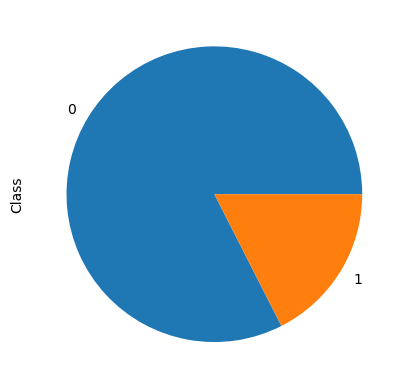

In [4]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

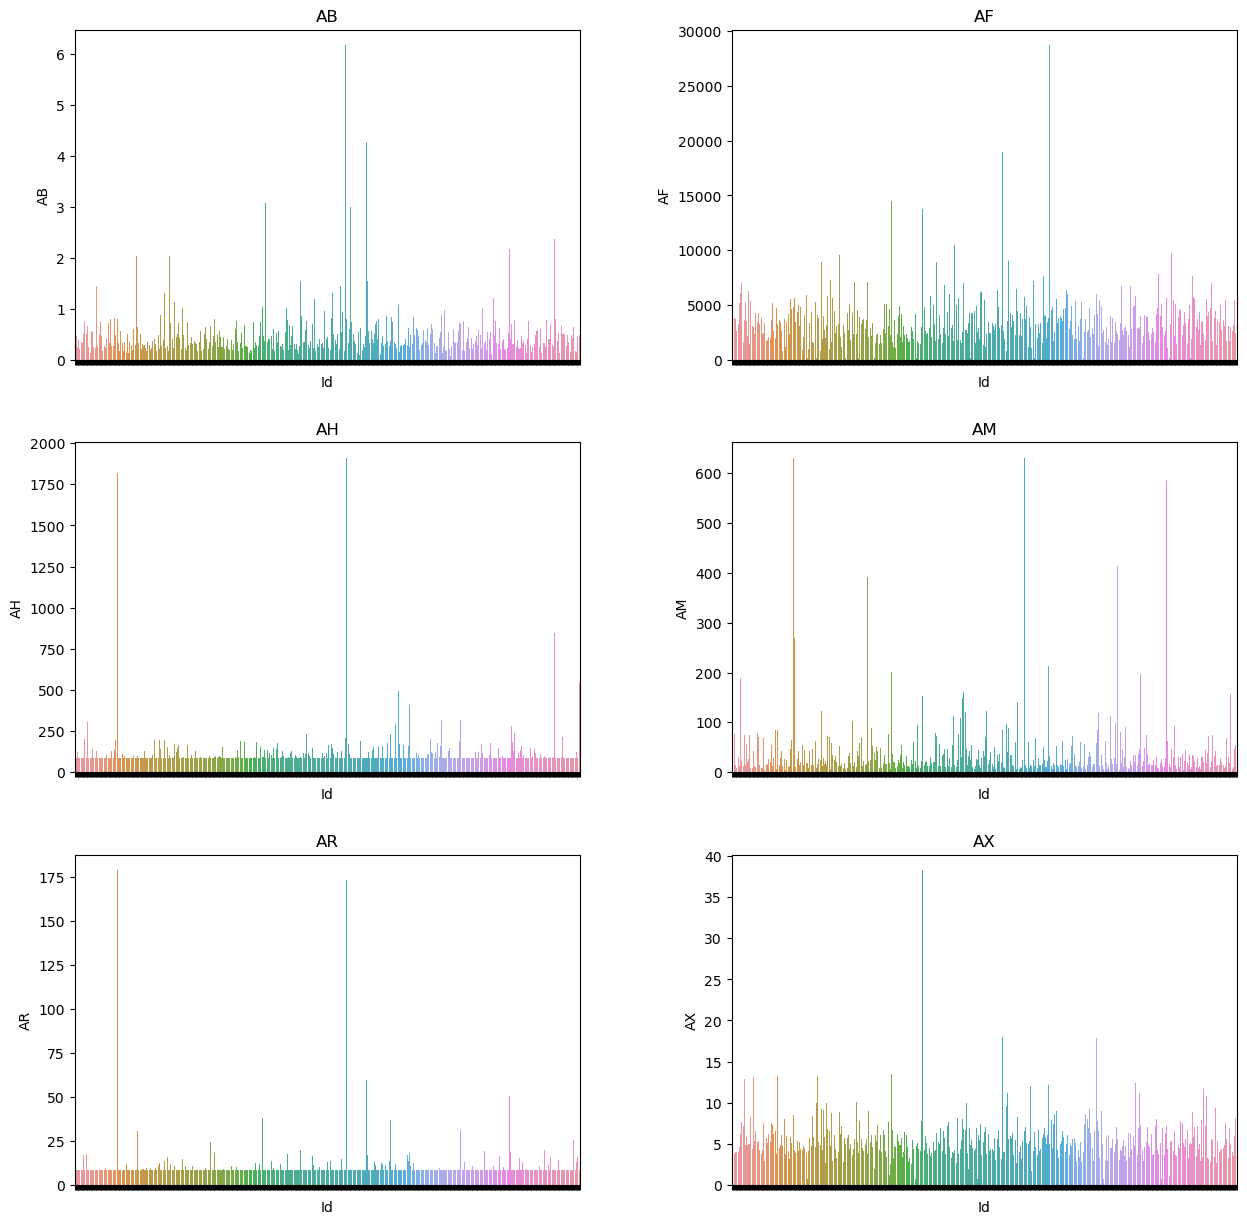

In [5]:
# 查看 float 数据的分布。先把他们搞到一个列表里。
NUM_FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

# 查看前六个。
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()

可以看到这些特征里有许多样本的值是异常大的，假如使用平均法来处理缺省值，直觉上来说会发生较大误差。

**TODO**: 参考 [这里](https://zhuanlan.zhihu.com/p/576512900) 想个解决办法。

In [6]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

dataset_df.drop(['Id'], axis=1, inplace=True)
categorical_columns = dataset_df.select_dtypes(include=['object']).columns.tolist()
for values in categorical_columns:
        print("Summary for {0}".format(values))
        print(dataset_df[values].value_counts())
        print("--------------------------")

Summary for EJ
B    395
A    222
Name: EJ, dtype: int64
--------------------------


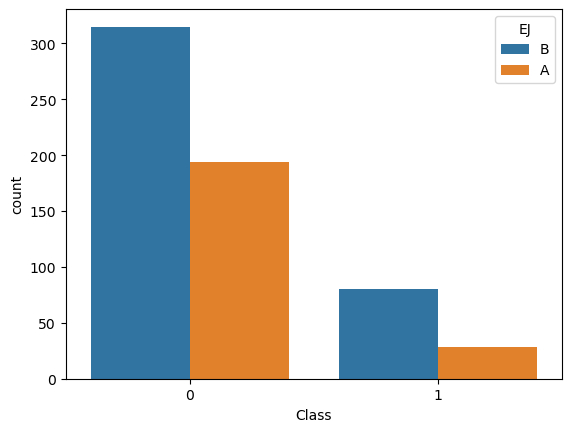

In [7]:
sns.countplot ( x = "Class", hue="EJ", data = dataset_df )
plt.show()

不难发现非数值类型的分布不均衡。

接下来，我们先简单装配一个简单的 NaN 处理。

In [8]:
column_names = list(dataset_df.columns.values)

def check_nan(column_names):
    for column in column_names:
        if dataset_df[column].isnull().sum() != 0:
            print("column: {0} --> {1}".format(column, dataset_df[column].isnull().sum()))
        
check_nan(column_names)

column: BQ --> 60
column: CB --> 2
column: CC --> 3
column: DU --> 1
column: EL --> 60
column: FC --> 1
column: FL --> 1
column: FS --> 2
column: GL --> 1


In [9]:
def fill_nan(column_names):
    for column in column_names:
        if dataset_df[column].isnull().sum() != 0:
            mean = dataset_df[column].mean()
            dataset_df[column].fillna(mean, inplace = True)
            
fill_nan(column_names)
dataset_df.isnull().values.any()

False

我们切分 features 和 label。

In [10]:
X = dataset_df.iloc[:, :-1]
y = dataset_df.iloc[:,-1]

counter = Counter(y)
print(counter)

Counter({0: 509, 1: 108})


One-Hot 编码，把两类别特征（Categorical feature）编码成 one-hot 编码。

In [11]:
enc = ce.OneHotEncoder(cols=["EJ"])
enc.fit(X)
encoded_x = enc.transform(X)
encoded_x.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000


## 模型训练部分

之后，我们把数据分成训练/测试集。

In [12]:
seed = 0
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(encoded_x, y, test_size = test_size,
                                                    random_state = seed)
ec1_eval_set = [(X_train, y_train), (X_test, y_test)]

print("train y shape: {0} and test y shape: {1}".format(y_train.shape, y_test.shape))

train y shape: (493,) and test y shape: (124,)


统计二分类的两类数量，不难发现 imbalanced。没病数量是有病数量的四倍。

In [13]:
positive_records = y_train.sum()
negative_records = len(y_train) - positive_records
estimate = negative_records / positive_records
print('y Estimate: %.3f' % estimate)

y Estimate: 4.478


In [14]:
model = XGBClassifier(colsample_bylevel = 0.6, 
                      colsample_bytree = 1.0, 
                      learning_rate = 0.3, 
                      max_depth = 2, 
                      n_estimators = 100, 
                      subsample = 1.0,   
                      scale_pos_weight = 5)

这里的 logloss 可能有问题，discussion 上有人讨论过。
**TODO**：研究一下这里的 logloss 是否使用错误。

In [15]:
model.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = ["error", "logloss"],
          eval_set = ec1_eval_set, verbose = True)

[0]	validation_0-error:0.29412	validation_0-logloss:0.58808	validation_1-error:0.44355	validation_1-logloss:0.64736
[1]	validation_0-error:0.12373	validation_0-logloss:0.49848	validation_1-error:0.24194	validation_1-logloss:0.58199
[2]	validation_0-error:0.13185	validation_0-logloss:0.44767	validation_1-error:0.24194	validation_1-logloss:0.53391
[3]	validation_0-error:0.12576	validation_0-logloss:0.39804	validation_1-error:0.23387	validation_1-logloss:0.49501
[4]	validation_0-error:0.09736	validation_0-logloss:0.35618	validation_1-error:0.19355	validation_1-logloss:0.45094
[5]	validation_0-error:0.07708	validation_0-logloss:0.32159	validation_1-error:0.14516	validation_1-logloss:0.42632
[6]	validation_0-error:0.07099	validation_0-logloss:0.30280	validation_1-error:0.13710	validation_1-logloss:0.40379
[7]	validation_0-error:0.05882	validation_0-logloss:0.28120	validation_1-error:0.11290	validation_1-logloss:0.38709
[8]	validation_0-error:0.05477	validation_0-logloss:0.26229	validation_1

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-error:0.00406	validation_0-logloss:0.07060	validation_1-error:0.08065	validation_1-logloss:0.27715
[36]	validation_0-error:0.00406	validation_0-logloss:0.06800	validation_1-error:0.08065	validation_1-logloss:0.27471
[37]	validation_0-error:0.00203	validation_0-logloss:0.06570	validation_1-error:0.08065	validation_1-logloss:0.27701
[38]	validation_0-error:0.00203	validation_0-logloss:0.06301	validation_1-error:0.08065	validation_1-logloss:0.26919
[39]	validation_0-error:0.00203	validation_0-logloss:0.06110	validation_1-error:0.08065	validation_1-logloss:0.26953
[40]	validation_0-error:0.00203	validation_0-logloss:0.05902	validation_1-error:0.08065	validation_1-logloss:0.27136
[41]	validation_0-error:0.00203	validation_0-logloss:0.05723	validation_1-error:0.08065	validation_1-logloss:0.27007
[42]	validation_0-error:0.00203	validation_0-logloss:0.05447	validation_1-error:0.08065	validation_1-logloss:0.26840
[43]	validation_0-error:0.00203	validation_0-logloss:0.05171	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

K-折交叉验证，取 9 训练 1 验证，选择出具有最好的准确率的模型。

In [16]:
Kfold = KFold(n_splits = 10)
results_K = cross_val_score(model, encoded_x, y, cv = Kfold)
print("KFold - Accuracy: {0}% ({1})%)".format(results_K.mean()*100, results_K.std()*100))

KFold - Accuracy: 93.68588048651509% (2.6552857153256966)%)


观察特征的重要性。
**TODO**：特征工程，用重要的特征搞一些新特征出来。

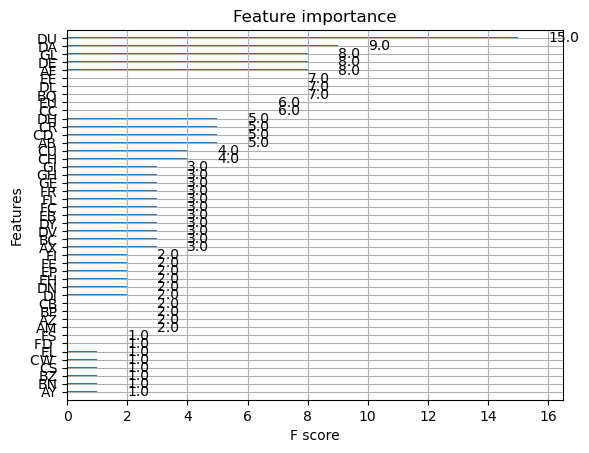

In [17]:
plot_importance(model)
plt.show()

## 提交生成部分

In [18]:
test_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

print(test_df.head(2))
print(test_df.isnull().values.any())

new_test_df = test_df.drop(['Id'], axis = 1)
new_test_df.head(2)

             Id   AB   AF   AH   AM   AR   AX   AY   AZ   BC  ...   FI   FL  \
0  00eed32682bb  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1  010ebe33f668  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

    FR   FS   GB   GE   GF   GH   GI   GL  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 57 columns]
False


,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
encoded_test_df = enc.transform(new_test_df)
encoded_test_df.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
class_0_pred = model.predict_proba(encoded_test_df)[:,0]
class_1_pred = model.predict_proba(encoded_test_df)[:,1]

test_df["class_0"] = pd.Series(class_0_pred).values
test_df["class_1"] = pd.Series(class_1_pred).values

In [21]:
submission_df = test_df[["Id", "class_0", "class_1"]]
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.321698,0.678302
1,010ebe33f668,0.321698,0.678302
2,02fa521e1838,0.321698,0.678302
3,040e15f562a2,0.321698,0.678302
4,046e85c7cc7f,0.321698,0.678302


In [22]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)